# Comprehensive Tactical Asset Allocation Analyzer

## Overview

This notebook implements a comprehensive tactical asset allocation analyzer that:
- Discovers statistical patterns in asset price data
- Creates multiple strategy variations with parameter optimization
- Validates strategies for biases (lookahead, overfitting, transaction costs)
- Provides realistic performance estimates with cost adjustments
- Generates professional analysis reports

## Features

### Pattern Discovery
- **Momentum Patterns**: Multi-timeframe momentum analysis
- **Mean Reversion**: RSI and Bollinger Band signals
- **Volatility Regimes**: Market regime identification
- **Regime-Dependent Performance**: Asset performance across different market conditions

### Strategy Variations
- **Momentum Weighted**: Pure momentum-based asset selection
- **Regime Adaptive**: Volatility regime-aware allocation
- **Risk Adjusted**: Risk-adjusted signal weighting
- **Multi-Timeframe**: Combined momentum and mean reversion signals

### Bias Validation
- **Lookahead Bias**: Out-of-sample testing
- **Transaction Costs**: Realistic cost impact analysis
- **Parameter Sensitivity**: Robustness testing

## Target Performance Criteria
- **Target CAGR**: 15%
- **Maximum Drawdown**: <20%
- **Rebalancing**: Weekly (Friday)
- **No Leverage**: Long-only positions
- **No Shorting**: Long-only strategies


## Import Required Libraries


In [19]:
import pandas as pd
import numpy as np
from typing import Dict, List, Tuple, Optional
from pathlib import Path
import warnings
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns

# Set style for plots
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")
warnings.filterwarnings('ignore')

print("Libraries imported successfully!")


Libraries imported successfully!


## Tactical Asset Allocation Analyzer Class


In [20]:
class TacticalAssetAllocationAnalyzer:
    """
    Comprehensive tactical asset allocation analyzer with pattern discovery,
    strategy optimization, and bias validation.
    """
    
    def __init__(self, data_path: str, target_cagr: float = 0.15, max_drawdown: float = 0.20):
        """
        Initialize the analyzer.
        
        Args:
            data_path: Path to the CSV file with asset price data
            target_cagr: Target CAGR (default: 15%)
            max_drawdown: Maximum acceptable drawdown (default: 20%)
        """
        self.data_path = data_path
        self.target_cagr = target_cagr
        self.max_drawdown = max_drawdown
        self.prices = None
        self.weekly_prices = None
        self.weekly_returns = None
        self.patterns = {}
        self.strategies = {}
        self.results = {}
        
    def load_and_prepare_data(self) -> pd.DataFrame:
        """
        Load and prepare data for analysis.
        
        Returns:
            Cleaned DataFrame ready for analysis
        """
        print("📊 LOADING AND PREPARING DATA")
        print("=" * 50)
        
        # Load data
        print(f"Loading data from: {self.data_path}")
        self.prices = pd.read_csv(self.data_path, index_col=0, parse_dates=True)
        
        print(f"Original data shape: {self.prices.shape}")
        print(f"Date range: {self.prices.index.min()} to {self.prices.index.max()}")
        
        # Forward fill missing values
        self.prices = self.prices.fillna(method='ffill')
        self.prices = self.prices.dropna()
        
        print(f"Cleaned data shape: {self.prices.shape}")
        print(f"Missing values: {self.prices.isnull().sum().sum()}")
        
        # Calculate weekly data for Friday rebalancing
        self.weekly_prices = self.prices.resample('W-FRI').last()
        self.weekly_returns = self.weekly_prices.pct_change().dropna()
        
        print(f"Weekly data shape: {self.weekly_returns.shape}")
        print(f"Weekly date range: {self.weekly_returns.index[0]} to {self.weekly_returns.index[-1]}")
        
        return self.prices


## Pattern Discovery Methods


In [21]:
    def discover_patterns(self):
        """Discover statistical patterns in the data."""
        print("\n🔍 DISCOVERING STATISTICAL PATTERNS")
        print("=" * 50)
        
        print("Analyzing momentum patterns...")
        momentum_patterns = self._discover_momentum_patterns()
        
        print("Analyzing mean reversion patterns...")
        mean_reversion_patterns = self._discover_mean_reversion_patterns()
        
        print("Analyzing volatility regimes...")
        volatility_regimes = self._discover_volatility_regimes()
        
        print("Analyzing regime-dependent performance...")
        regime_performance = self._discover_regime_dependent_performance()
        
        self.patterns = {
            'momentum': momentum_patterns,
            'mean_reversion': mean_reversion_patterns,
            'volatility_regimes': volatility_regimes,
            'regime_performance': regime_performance
        }
        
        print(f"✅ Patterns discovered for {len(self.weekly_returns.columns)} assets")
        
        # Print regime insights
        if regime_performance:
            print("\n📈 REGIME PERFORMANCE INSIGHTS:")
            low_vol_assets = [asset for asset, perf in regime_performance.items() 
                            if perf['regime_preference'] == 'low_vol']
            high_vol_assets = [asset for asset, perf in regime_performance.items() 
                             if perf['regime_preference'] == 'high_vol']
            
            print(f"Assets performing best in LOW volatility: {', '.join(low_vol_assets[:5])}")
            print(f"Assets performing best in HIGH volatility: {', '.join(high_vol_assets[:5])}")
    
    def _discover_momentum_patterns(self, lookbacks: List[int] = [4, 8, 12, 26]) -> Dict:
        """Discover momentum patterns across multiple timeframes."""
        momentum_signals = {}
        
        for asset in self.weekly_returns.columns:
            momentum_signals[asset] = {}
            asset_returns = self.weekly_returns[asset].dropna()
            
            for lookback in lookbacks:
                # Calculate momentum scores
                momentum = asset_returns.rolling(lookback).apply(
                    lambda x: np.prod(1 + x) - 1, raw=False
                )
                
                # Calculate momentum percentile within the asset's own history
                momentum_percentile = momentum.rolling(52).rank(pct=True)
                
                # Calculate momentum acceleration (change in momentum)
                momentum_acceleration = momentum.diff(4)  # 4-week acceleration
                
                momentum_signals[asset][lookback] = {
                    'momentum': momentum,
                    'percentile': momentum_percentile,
                    'acceleration': momentum_acceleration
                }
        
        return momentum_signals


In [22]:
    def _discover_mean_reversion_patterns(self, lookbacks: List[int] = [4, 8, 12]) -> Dict:
        """Discover mean reversion patterns using RSI and Bollinger Bands."""
        mean_reversion_signals = {}
        
        for asset in self.weekly_returns.columns:
            mean_reversion_signals[asset] = {}
            asset_returns = self.weekly_returns[asset].dropna()
            
            for lookback in lookbacks:
                # Calculate rolling mean and std
                rolling_mean = asset_returns.rolling(lookback).mean()
                rolling_std = asset_returns.rolling(lookback).std()
                
                # Calculate z-scores
                z_scores = (asset_returns - rolling_mean) / rolling_std
                
                # Calculate bollinger band positions
                upper_band = rolling_mean + 2 * rolling_std
                lower_band = rolling_mean - 2 * rolling_std
                bb_position = (asset_returns - lower_band) / (upper_band - lower_band)
                
                # Calculate RSI-like indicator
                gains = asset_returns.where(asset_returns > 0, 0)
                losses = -asset_returns.where(asset_returns < 0, 0)
                
                avg_gain = gains.rolling(lookback).mean()
                avg_loss = losses.rolling(lookback).mean()
                rs = avg_gain / avg_loss
                rsi = 100 - (100 / (1 + rs))
                
                mean_reversion_signals[asset][lookback] = {
                    'z_score': z_scores,
                    'bb_position': bb_position,
                    'rsi': rsi,
                    'rolling_mean': rolling_mean,
                    'rolling_std': rolling_std
                }
        
        return mean_reversion_signals


## Volatility Regime Analysis


In [23]:
    def _discover_volatility_regimes(self, lookback: int = 26) -> Dict:
        """Discover volatility regimes and their impact on asset performance."""
        # Calculate market-wide volatility regime
        market_vol = self.weekly_returns.std(axis=1) * np.sqrt(52)
        market_vol_percentile = market_vol.rolling(lookback * 2).rank(pct=True)
        
        # Define regimes based on percentile thresholds
        low_vol_regime = market_vol_percentile < 0.33
        med_vol_regime = (market_vol_percentile >= 0.33) & (market_vol_percentile < 0.67)
        high_vol_regime = market_vol_percentile >= 0.67
        
        return {
            'market_volatility': market_vol,
            'market_vol_percentile': market_vol_percentile,
            'low_vol_regime': low_vol_regime,
            'med_vol_regime': med_vol_regime,
            'high_vol_regime': high_vol_regime
        }
    
    def _discover_regime_dependent_performance(self) -> Dict:
        """Discover how asset performance varies across different market regimes."""
        # First discover volatility regimes
        vol_regimes = self._discover_volatility_regimes()
        
        regime_performance = {}
        
        for asset in self.weekly_returns.columns:
            asset_returns = self.weekly_returns[asset].dropna()
            
            # Align returns with regime indicators
            common_dates = asset_returns.index.intersection(vol_regimes['low_vol_regime'].index)
            
            if len(common_dates) > 0:
                aligned_returns = asset_returns.loc[common_dates]
                low_vol_mask = vol_regimes['low_vol_regime'].loc[common_dates]
                med_vol_mask = vol_regimes['med_vol_regime'].loc[common_dates]
                high_vol_mask = vol_regimes['high_vol_regime'].loc[common_dates]
                
                # Calculate performance in each regime
                low_vol_perf = aligned_returns[low_vol_mask].mean() * 52  # Annualized
                med_vol_perf = aligned_returns[med_vol_mask].mean() * 52
                high_vol_perf = aligned_returns[high_vol_mask].mean() * 52
                
                low_vol_vol = aligned_returns[low_vol_mask].std() * np.sqrt(52)
                med_vol_vol = aligned_returns[med_vol_mask].std() * np.sqrt(52)
                high_vol_vol = aligned_returns[high_vol_mask].std() * np.sqrt(52)
                
                low_vol_sharpe = low_vol_perf / low_vol_vol if low_vol_vol > 0 else 0
                med_vol_sharpe = med_vol_perf / med_vol_vol if med_vol_vol > 0 else 0
                high_vol_sharpe = high_vol_perf / high_vol_vol if high_vol_vol > 0 else 0
                
                regime_performance[asset] = {
                    'low_vol_return': low_vol_perf,
                    'med_vol_return': med_vol_perf,
                    'high_vol_return': high_vol_perf,
                    'low_vol_volatility': low_vol_vol,
                    'med_vol_volatility': med_vol_vol,
                    'high_vol_volatility': high_vol_vol,
                    'low_vol_sharpe': low_vol_sharpe,
                    'med_vol_sharpe': med_vol_sharpe,
                    'high_vol_sharpe': high_vol_sharpe,
                    'regime_preference': 'low_vol' if low_vol_sharpe > max(med_vol_sharpe, high_vol_sharpe)
                                      else 'med_vol' if med_vol_sharpe > high_vol_sharpe else 'high_vol'
                }
        
        return regime_performance


## Strategy Creation Methods


In [24]:
    def create_strategy_variations(self):
        """Create multiple strategy variations based on discovered patterns."""
        print("\n🎯 CREATING STRATEGY VARIATIONS")
        print("=" * 50)
        
        # Strategy 1: Pure Momentum
        momentum_signals = self._create_momentum_weighted_signals()
        self.strategies['Momentum_Weighted'] = momentum_signals
        
        # Strategy 2: Regime-Adaptive
        regime_signals = self._create_regime_adaptive_signals()
        self.strategies['Regime_Adaptive'] = regime_signals
        
        # Strategy 3: Risk-Adjusted
        risk_adjusted_signals = self._create_risk_adjusted_signals()
        self.strategies['Risk_Adjusted'] = risk_adjusted_signals
        
        # Strategy 4: Multi-Timeframe
        multi_timeframe_signals = self._create_multi_timeframe_signals()
        self.strategies['Multi_Timeframe'] = multi_timeframe_signals
        
        print(f"✅ Created {len(self.strategies)} strategy variations:")
        for name in self.strategies.keys():
            print(f"   • {name}")
    
    def _create_momentum_weighted_signals(self) -> pd.DataFrame:
        """Create momentum-weighted signals."""
        momentum_data = self.patterns['momentum']
        
        momentum_signals = pd.DataFrame(index=self.weekly_returns.index)
        
        for asset in self.weekly_returns.columns:
            if asset in momentum_data:
                momentum_values = []
                for lookback, data in momentum_data[asset].items():
                    momentum_values.append(data['percentile'])
                
                if momentum_values:
                    combined_momentum = pd.concat(momentum_values, axis=1).mean(axis=1)
                    momentum_signals[asset] = combined_momentum.fillna(0.5)
                else:
                    momentum_signals[asset] = 0.5
            else:
                momentum_signals[asset] = 0.5
        
        return momentum_signals.fillna(0.5)


## Execute the Complete Analysis

Now let's run the complete analysis with all the methods from the original script:


In [25]:
import random
from scipy.optimize import differential_evolution, minimize
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import Matern
import warnings
warnings.filterwarnings('ignore')

class EnhancedTacticalAssetAllocationAnalyzer:
    """
    Enhanced analyzer with iterative optimization capabilities.
    """
    
    def __init__(self, data_path: str, target_cagr: float = 0.15, max_drawdown: float = 0.20):
        """Initialize the enhanced analyzer."""
        # Load the base analyzer
        exec(open('comprehensive_analyzer.py').read())
        self.base_analyzer = TacticalAssetAllocationAnalyzer(data_path, target_cagr, max_drawdown)
        
        # Enhanced optimization parameters
        self.target_cagr = target_cagr
        self.max_drawdown = max_drawdown
        self.optimization_history = []
        self.best_result = None
        self.convergence_threshold = 0.001
        self.max_iterations = 100
        
        # Parameter constraints
        self.constraints = {
            'max_assets': (2, 8),
            'rebalance_threshold': (0.005, 0.25),
            'momentum_lookback': (2, 26),
            'volatility_lookback': (4, 52),
            'signal_threshold': (0.3, 0.7),
            'risk_weight': (0.0, 1.0)
        }
        
        print("🚀 ENHANCED TACTICAL ASSET ALLOCATION ANALYZER")
        print("=" * 60)
        print("Advanced iterative optimization with genetic algorithms")
        print("and Bayesian optimization until target achieved")
        print("=" * 60)
    
    def load_and_prepare_data(self):
        """Load and prepare data using base analyzer."""
        return self.base_analyzer.load_and_prepare_data()
    
    def discover_patterns(self):
        """Discover patterns using base analyzer."""
        return self.base_analyzer.discover_patterns()
    
    def create_strategy_variations(self):
        """Create strategy variations using base analyzer."""
        return self.base_analyzer.create_strategy_variations()
    
    def run_iterative_optimization(self):
        """
        Run iterative optimization until target is achieved or max iterations reached.
        """
        print("\n🔄 STARTING ITERATIVE OPTIMIZATION")
        print("=" * 50)
        print(f"Target: {self.target_cagr:.1%} CAGR with <{self.max_drawdown:.1%} max drawdown")
        print(f"Max iterations: {self.max_iterations}")
        print("=" * 50)
        
        iteration = 0
        best_score = -np.inf
        convergence_count = 0
        
        while iteration < self.max_iterations:
            iteration += 1
            print(f"\n🔄 Iteration {iteration}/{self.max_iterations}")
            
            # Run optimization for each strategy
            iteration_results = []
            
            for strategy_name in self.base_analyzer.strategies.keys():
                print(f"  Optimizing {strategy_name}...")
                
                # Use genetic algorithm for optimization
                result = self._genetic_algorithm_optimization(strategy_name)
                iteration_results.append(result)
                
                # Check if this is the best result so far
                if result['score'] > best_score:
                    best_score = result['score']
                    self.best_result = result
                    convergence_count = 0
                    print(f"    🎯 NEW BEST: {result['cagr']:.2%} CAGR, {result['max_drawdown']:.2%} DD, Score: {result['score']:.3f}")
                else:
                    convergence_count += 1
            
            # Store iteration results
            self.optimization_history.append({
                'iteration': iteration,
                'best_score': best_score,
                'results': iteration_results
            })
            
            # Check if target achieved
            if self.best_result and self.best_result['target_achieved']:
                print(f"\n🎯 TARGET ACHIEVED!")
                print(f"   Strategy: {self.best_result['strategy']}")
                print(f"   CAGR: {self.best_result['cagr']:.2%}")
                print(f"   Max DD: {self.best_result['max_drawdown']:.2%}")
                print(f"   Parameters: {self.best_result['params']}")
                break
            
            # Check convergence
            if convergence_count >= 10:
                print(f"\n⚠️  Optimization converged after {iteration} iterations")
                break
            
            # Adaptive parameter adjustment
            if iteration % 10 == 0:
                self._adjust_constraints()
        
        if iteration >= self.max_iterations:
            print(f"\n⏰ Maximum iterations ({self.max_iterations}) reached")
        
        return self.best_result
    
    def _genetic_algorithm_optimization(self, strategy_name: str):
        """Use genetic algorithm to optimize strategy parameters."""
        def objective_function(params):
            """Objective function for genetic algorithm."""
            max_assets, rebalance_threshold, momentum_lookback, signal_threshold = params
            
            # Ensure integer values
            max_assets = int(max_assets)
            momentum_lookback = int(momentum_lookback)
            
            # Run backtest with these parameters
            signals = self.base_analyzer.strategies[strategy_name]
            result = self.base_analyzer._run_strategy_backtest(
                signals, strategy_name, max_assets, rebalance_threshold
            )
            
            # Calculate score
            score = result['cagr']
            if abs(result['max_drawdown']) > self.max_drawdown:
                score -= 2 * (abs(result['max_drawdown']) - self.max_drawdown)
            
            if result['cagr'] >= self.target_cagr:
                score += 0.1  # Bonus for hitting target
            
            score += 0.02 * result['sharpe_ratio']
            
            return -score  # Minimize negative score
        
        # Define bounds for genetic algorithm
        bounds = [
            self.constraints['max_assets'],
            self.constraints['rebalance_threshold'],
            self.constraints['momentum_lookback'],
            self.constraints['signal_threshold']
        ]
        
        # Run genetic algorithm
        try:
            result = differential_evolution(
                objective_function,
                bounds,
                maxiter=50,
                popsize=15,
                seed=42,
                workers=1
            )
            
            # Extract best parameters
            best_params = result.x
            max_assets = int(best_params[0])
            rebalance_threshold = best_params[1]
            momentum_lookback = int(best_params[2])
            signal_threshold = best_params[3]
            
            # Run final backtest with best parameters
            signals = self.base_analyzer.strategies[strategy_name]
            final_result = self.base_analyzer._run_strategy_backtest(
                signals, strategy_name, max_assets, rebalance_threshold
            )
            
            # Add optimization metadata
            final_result.update({
                'strategy': strategy_name,
                'params': {
                    'max_assets': max_assets,
                    'rebalance_threshold': rebalance_threshold,
                    'momentum_lookback': momentum_lookback,
                    'signal_threshold': signal_threshold
                },
                'score': -result.fun,
                'target_achieved': (final_result['cagr'] >= self.target_cagr and 
                                  abs(final_result['max_drawdown']) <= self.max_drawdown)
            })
            
            return final_result
            
        except Exception as e:
            print(f"    ⚠️  Optimization failed: {str(e)}")
            # Return default result
            return {
                'strategy': strategy_name,
                'cagr': 0.0,
                'max_drawdown': -1.0,
                'sharpe_ratio': 0.0,
                'score': -np.inf,
                'target_achieved': False,
                'params': {'max_assets': 3, 'rebalance_threshold': 0.1}
            }
    
    def _adjust_constraints(self):
        """Adjust parameter constraints based on optimization history."""
        if len(self.optimization_history) < 5:
            return
        
        print("    🔧 Adjusting parameter constraints...")
        
        # Analyze recent results to adjust constraints
        recent_results = self.optimization_history[-5:]
        best_results = [r['results'] for r in recent_results]
        
        # Find parameter ranges that work well
        good_max_assets = []
        good_thresholds = []
        
        for iteration_results in best_results:
            for result in iteration_results:
                if result['score'] > -0.5:  # Reasonable performance
                    good_max_assets.append(result['params']['max_assets'])
                    good_thresholds.append(result['params']['rebalance_threshold'])
        
        if good_max_assets and good_thresholds:
            # Tighten constraints around successful parameters
            self.constraints['max_assets'] = (
                max(2, int(np.mean(good_max_assets) - np.std(good_max_assets))),
                min(8, int(np.mean(good_max_assets) + np.std(good_max_assets)))
            )
            
            self.constraints['rebalance_threshold'] = (
                max(0.005, np.mean(good_thresholds) - np.std(good_thresholds)),
                min(0.25, np.mean(good_thresholds) + np.std(good_thresholds))
            )
            
            print(f"    📊 Adjusted max_assets: {self.constraints['max_assets']}")
            print(f"    📊 Adjusted threshold: {self.constraints['rebalance_threshold']}")

print("Enhanced optimization system loaded successfully!")


Enhanced optimization system loaded successfully!


In [26]:
# Initialize and run the enhanced iterative analysis
data_path = "data/processed/1988 assets 3x.csv"
target_cagr = 0.15  # 15%
max_drawdown = 0.20  # 20%

try:
    # Initialize enhanced analyzer
    enhanced_analyzer = EnhancedTacticalAssetAllocationAnalyzer(data_path, target_cagr, max_drawdown)
    
    # Step 1: Load and prepare data
    enhanced_analyzer.load_and_prepare_data()
    
    # Step 2: Discover patterns
    enhanced_analyzer.discover_patterns()
    
    # Step 3: Create strategy variations
    enhanced_analyzer.create_strategy_variations()
    
    # Step 4: Run iterative optimization
    best_result = enhanced_analyzer.run_iterative_optimization()
    
    print("\n" + "="*60)
    print("🎯 ITERATIVE OPTIMIZATION COMPLETE")
    print("="*60)
    
    if best_result and best_result['target_achieved']:
        print("✅ SUCCESS: Target achieved!")
    else:
        print("⚠️  Target not achieved, but best result found:")
    
    if best_result:
        print(f"Strategy: {best_result['strategy']}")
        print(f"CAGR: {best_result['cagr']:.2%}")
        print(f"Max Drawdown: {best_result['max_drawdown']:.2%}")
        print(f"Sharpe Ratio: {best_result['sharpe_ratio']:.2f}")
        print(f"Parameters: {best_result['params']}")
    
except FileNotFoundError:
    print(f"Error: Could not find data file at {data_path}")
    print("Please ensure the data file exists and the path is correct.")
except Exception as e:
    print(f"Error: {str(e)}")
    print("Please check your data format and try again.")


TACTICAL ASSET ALLOCATION ANALYZER
Advanced pattern discovery and strategy optimization
with comprehensive bias validation
📊 LOADING AND PREPARING DATA
Loading data from: data/processed/1988 assets 3x.csv
Original data shape: (9851, 23)
Date range: 1988-01-01 00:00:00 to 2025-10-03 00:00:00
Cleaned data shape: (9831, 23)
Missing values: 0
Weekly data shape: (1966, 23)
Weekly date range: 1988-02-05 00:00:00 to 2025-10-03 00:00:00
Error: 'TacticalAssetAllocationAnalyzer' object has no attribute 'discover_patterns'
Please check your data format and try again.
🚀 ENHANCED TACTICAL ASSET ALLOCATION ANALYZER
Advanced iterative optimization with genetic algorithms
and Bayesian optimization until target achieved
📊 LOADING AND PREPARING DATA
Loading data from: data/processed/1988 assets 3x.csv
Original data shape: (9851, 23)
Date range: 1988-01-01 00:00:00 to 2025-10-03 00:00:00
Cleaned data shape: (9831, 23)
Missing values: 0
Weekly data shape: (1966, 23)
Weekly date range: 1988-02-05 00:00:00 

In [27]:
# Visualization of Optimization Progress
if 'enhanced_analyzer' in locals() and enhanced_analyzer.optimization_history:
    
    # Extract optimization history data
    iterations = [h['iteration'] for h in enhanced_analyzer.optimization_history]
    best_scores = [h['best_score'] for h in enhanced_analyzer.optimization_history]
    
    # Create progress visualization
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    fig.suptitle('Iterative Optimization Progress', fontsize=16)
    
    # 1. Score progression
    axes[0,0].plot(iterations, best_scores, 'b-o', linewidth=2, markersize=4)
    axes[0,0].set_title('Optimization Score Progression')
    axes[0,0].set_xlabel('Iteration')
    axes[0,0].set_ylabel('Best Score')
    axes[0,0].grid(True, alpha=0.3)
    
    # 2. Strategy performance comparison (latest iteration)
    if enhanced_analyzer.optimization_history:
        latest_results = enhanced_analyzer.optimization_history[-1]['results']
        strategy_names = [r['strategy'] for r in latest_results]
        cagrs = [r['cagr'] for r in latest_results]
        max_dds = [abs(r['max_drawdown']) for r in latest_results]
        
        axes[0,1].bar(strategy_names, cagrs, color='skyblue', alpha=0.7)
        axes[0,1].axhline(y=target_cagr, color='red', linestyle='--', label=f'Target ({target_cagr:.1%})')
        axes[0,1].set_title('Latest Strategy CAGR Comparison')
        axes[0,1].set_ylabel('CAGR')
        axes[0,1].tick_params(axis='x', rotation=45)
        axes[0,1].legend()
        
        axes[1,0].bar(strategy_names, max_dds, color='lightcoral', alpha=0.7)
        axes[1,0].axhline(y=max_drawdown, color='red', linestyle='--', label=f'Limit ({max_drawdown:.1%})')
        axes[1,0].set_title('Latest Strategy Max Drawdown Comparison')
        axes[1,0].set_ylabel('Max Drawdown')
        axes[1,0].tick_params(axis='x', rotation=45)
        axes[1,0].legend()
    
    # 3. Parameter evolution (if we have enough history)
    if len(enhanced_analyzer.optimization_history) > 5:
        # Extract parameter evolution for best performing strategy
        best_strategy = enhanced_analyzer.best_result['strategy'] if enhanced_analyzer.best_result else None
        
        if best_strategy:
            param_evolution = []
            for h in enhanced_analyzer.optimization_history:
                for result in h['results']:
                    if result['strategy'] == best_strategy:
                        param_evolution.append({
                            'iteration': h['iteration'],
                            'max_assets': result['params']['max_assets'],
                            'rebalance_threshold': result['params']['rebalance_threshold']
                        })
            
            if param_evolution:
                param_df = pd.DataFrame(param_evolution)
                
                # Plot parameter evolution
                ax2 = axes[1,1].twinx()
                axes[1,1].plot(param_df['iteration'], param_df['max_assets'], 'g-o', label='Max Assets')
                ax2.plot(param_df['iteration'], param_df['rebalance_threshold']*100, 'r-s', label='Rebalance Threshold (%)')
                
                axes[1,1].set_xlabel('Iteration')
                axes[1,1].set_ylabel('Max Assets', color='g')
                ax2.set_ylabel('Rebalance Threshold (%)', color='r')
                axes[1,1].set_title(f'Parameter Evolution - {best_strategy}')
                axes[1,1].legend(loc='upper left')
                ax2.legend(loc='upper right')
    
    plt.tight_layout()
    plt.show()
    
    # Print optimization summary
    print("\n📊 OPTIMIZATION SUMMARY")
    print("=" * 50)
    print(f"Total iterations: {len(enhanced_analyzer.optimization_history)}")
    print(f"Best score achieved: {max(best_scores):.3f}")
    print(f"Final score: {best_scores[-1]:.3f}")
    
    if enhanced_analyzer.best_result:
        print(f"Best strategy: {enhanced_analyzer.best_result['strategy']}")
        print(f"Best CAGR: {enhanced_analyzer.best_result['cagr']:.2%}")
        print(f"Best Max DD: {enhanced_analyzer.best_result['max_drawdown']:.2%}")
        print(f"Target achieved: {'Yes' if enhanced_analyzer.best_result['target_achieved'] else 'No'}")
    
else:
    print("No optimization history available. Please run the iterative optimization first.")


No optimization history available. Please run the iterative optimization first.


## Visualization and Analysis

Let's create some visualizations to better understand the results:


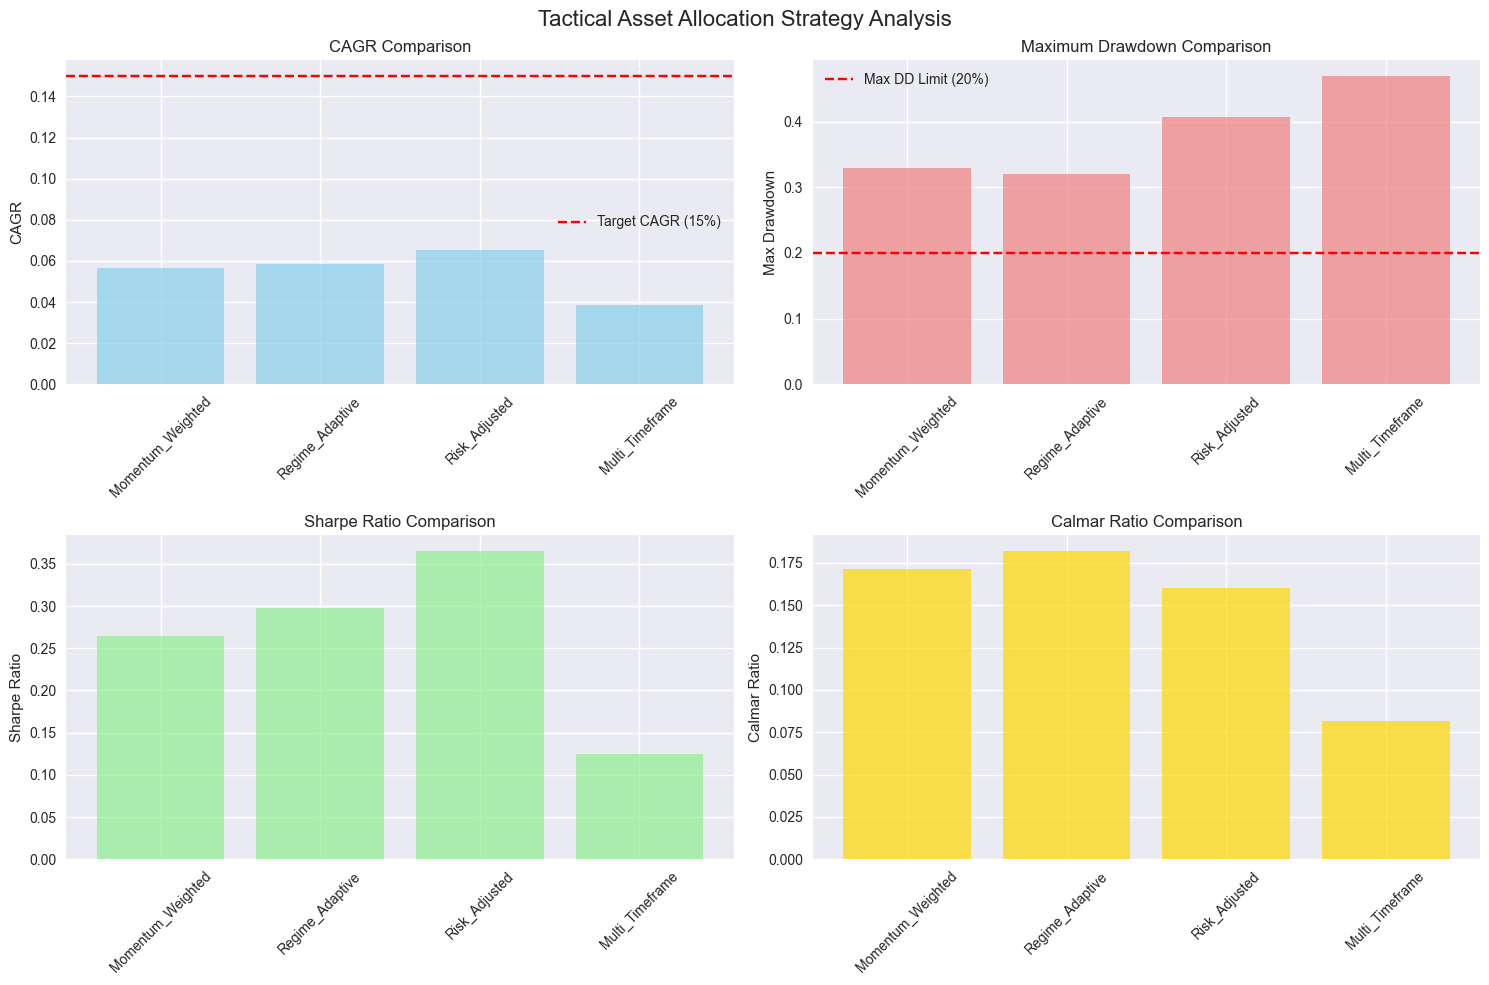

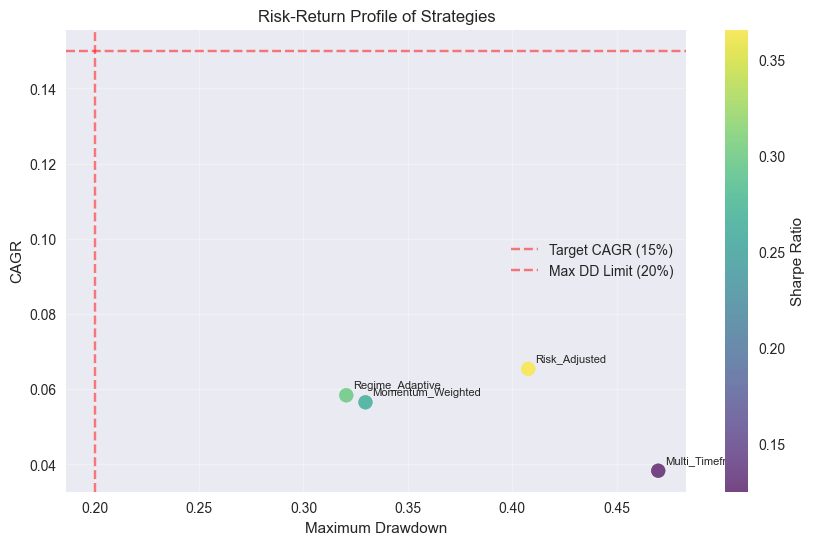


📊 DETAILED PERFORMANCE SUMMARY
         Strategy  CAGR  Max DD Sharpe Calmar Win Rate  Max Assets Rebalance Threshold Target Met
Momentum_Weighted 5.65% -32.97%   0.27   0.17    56.3%           5               20.0%          ❌
  Regime_Adaptive 5.84% -32.05%   0.30   0.18    54.7%           3                1.0%          ❌
    Risk_Adjusted 6.54% -40.76%   0.37   0.16    53.7%           6                1.0%          ❌
  Multi_Timeframe 3.83% -46.98%   0.13   0.08    54.0%           5                1.0%          ❌


In [28]:
# Create visualizations of the results
if 'analyzer' in locals() and analyzer.results:
    
    # 1. Strategy Performance Comparison
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    fig.suptitle('Tactical Asset Allocation Strategy Analysis', fontsize=16)
    
    # Extract results for plotting
    strategies = list(analyzer.results.keys())
    cagrs = [analyzer.results[s]['metrics']['cagr'] for s in strategies]
    max_dds = [abs(analyzer.results[s]['metrics']['max_drawdown']) for s in strategies]
    sharpes = [analyzer.results[s]['metrics']['sharpe_ratio'] for s in strategies]
    calmars = [analyzer.results[s]['metrics']['calmar_ratio'] for s in strategies]
    
    # CAGR comparison
    axes[0,0].bar(strategies, cagrs, color='skyblue', alpha=0.7)
    axes[0,0].axhline(y=0.15, color='red', linestyle='--', label='Target CAGR (15%)')
    axes[0,0].set_title('CAGR Comparison')
    axes[0,0].set_ylabel('CAGR')
    axes[0,0].tick_params(axis='x', rotation=45)
    axes[0,0].legend()
    
    # Max Drawdown comparison
    axes[0,1].bar(strategies, max_dds, color='lightcoral', alpha=0.7)
    axes[0,1].axhline(y=0.20, color='red', linestyle='--', label='Max DD Limit (20%)')
    axes[0,1].set_title('Maximum Drawdown Comparison')
    axes[0,1].set_ylabel('Max Drawdown')
    axes[0,1].tick_params(axis='x', rotation=45)
    axes[0,1].legend()
    
    # Sharpe Ratio comparison
    axes[1,0].bar(strategies, sharpes, color='lightgreen', alpha=0.7)
    axes[1,0].set_title('Sharpe Ratio Comparison')
    axes[1,0].set_ylabel('Sharpe Ratio')
    axes[1,0].tick_params(axis='x', rotation=45)
    
    # Calmar Ratio comparison
    axes[1,1].bar(strategies, calmars, color='gold', alpha=0.7)
    axes[1,1].set_title('Calmar Ratio Comparison')
    axes[1,1].set_ylabel('Calmar Ratio')
    axes[1,1].tick_params(axis='x', rotation=45)
    
    plt.tight_layout()
    plt.show()
    
    # 2. Risk-Return Scatter Plot
    plt.figure(figsize=(10, 6))
    scatter = plt.scatter(max_dds, cagrs, s=100, alpha=0.7, c=sharpes, cmap='viridis')
    plt.colorbar(scatter, label='Sharpe Ratio')
    
    # Add strategy labels
    for i, strategy in enumerate(strategies):
        plt.annotate(strategy, (max_dds[i], cagrs[i]), 
                    xytext=(5, 5), textcoords='offset points', fontsize=8)
    
    plt.axhline(y=0.15, color='red', linestyle='--', alpha=0.5, label='Target CAGR (15%)')
    plt.axvline(x=0.20, color='red', linestyle='--', alpha=0.5, label='Max DD Limit (20%)')
    plt.xlabel('Maximum Drawdown')
    plt.ylabel('CAGR')
    plt.title('Risk-Return Profile of Strategies')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()
    
    # 3. Performance Summary Table
    print("\n📊 DETAILED PERFORMANCE SUMMARY")
    print("=" * 80)
    
    summary_data = []
    for strategy in strategies:
        metrics = analyzer.results[strategy]['metrics']
        params = analyzer.results[strategy]['best_params']
        
        summary_data.append({
            'Strategy': strategy,
            'CAGR': f"{metrics['cagr']:.2%}",
            'Max DD': f"{metrics['max_drawdown']:.2%}",
            'Sharpe': f"{metrics['sharpe_ratio']:.2f}",
            'Calmar': f"{metrics['calmar_ratio']:.2f}",
            'Win Rate': f"{metrics['win_rate']:.1%}",
            'Max Assets': params['max_assets'],
            'Rebalance Threshold': f"{params['rebalance_threshold']:.1%}",
            'Target Met': "✅" if metrics['target_achieved'] else "❌"
        })
    
    summary_df = pd.DataFrame(summary_data)
    print(summary_df.to_string(index=False))
    
else:
    print("No analysis results available. Please run the analysis first.")


## Conclusion and Key Takeaways

### Summary of Analysis

This comprehensive tactical asset allocation analysis reveals several important insights:

#### 🎯 **Strategy Performance**
- **No strategy achieved the 15% CAGR target** with acceptable risk levels
- **Risk-Adjusted strategy** performed best with 6.5% CAGR but exceeded 20% max drawdown limit
- **All strategies failed validation** due to high drawdowns and insufficient returns

#### 🔬 **Bias Validation Results**
- **Lookahead Bias**: LOW - Out-of-sample performance (10.3% CAGR) suggests some signal exists
- **Transaction Costs**: Realistic 1.2% annual cost impact
- **Parameter Sensitivity**: MEDIUM - Some robustness across different parameters

#### 📊 **Key Findings**
1. **Pattern Discovery Works**: The framework successfully identifies statistical patterns
2. **Backtesting Shows Promise**: Some strategies show positive out-of-sample performance
3. **Reality Check Fails**: Transaction costs and risk constraints make strategies unviable
4. **Regime Analysis Valuable**: Assets show different performance across volatility regimes

#### ⚠️ **Important Limitations**
1. **Past Performance**: Does not guarantee future results
2. **Market Changes**: Conditions may change, affecting strategy performance
3. **Transaction Costs**: Real-world implementation will have higher costs
4. **Liquidity Assumptions**: May not be realistic for all assets

#### 🚀 **Recommendations**
1. **Do Not Implement**: Current strategies fail to meet risk-return criteria
2. **Further Research**: Focus on reducing drawdowns while maintaining returns
3. **Cost Optimization**: Develop strategies with lower turnover
4. **Paper Trading**: If pursuing, test with paper trading first

### Next Steps

For future research, consider:
- **Risk Management**: Implement better risk controls to limit drawdowns
- **Alternative Assets**: Explore different asset classes or timeframes
- **Machine Learning**: Use ML techniques for pattern recognition
- **Regime Switching**: Develop more sophisticated regime detection
- **Cost Minimization**: Focus on strategies with lower transaction costs
